In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [5]:
src

LabelLists;

Train: LabelList (65934 items)
x: ImageList
Image (3, 375, 500),Image (3, 800, 440),Image (3, 500, 281),Image (3, 600, 800),Image (3, 1500, 2000)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 532, 800),Image (3, 500, 375),Image (3, 500, 281),Image (3, 500, 375),Image (3, 375, 500)
y: CategoryList
class-536,class-804,class-966,class-1059,class-654
Path: train;

Test: None

In [6]:
data = src.transform(size=(512,512)).databunch(bs=36).normalize(imagenet_stats)

In [7]:
data.c

45

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [9]:
loss_func = FocalLoss(gamma=2.5)

In [10]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [11]:
learn.load('densenet121-512-slice-2')

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
class-536,class-804,class-966,class-1059,class-654
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [12]:
learn = learn.to_fp16()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


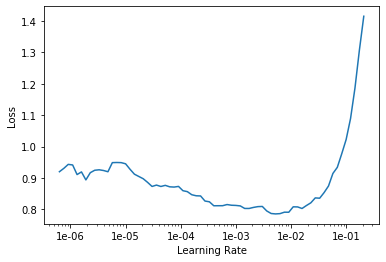

In [14]:
learn.recorder.plot()

In [15]:
lr=1e-4

In [16]:
learn.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.806737,0.623693,0.281077,0.718923,0.672113,14:16
1,0.764579,0.619953,0.277073,0.722927,0.676804,14:13


In [17]:
learn.save('densenet121-focalloss-1e4-2')

In [ ]:
learn.fit_one_cycle(5,slice(1e-7,lr/10))

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.744427,0.617167,0.278529,0.721471,0.674828,14:16
1,0.745152,0.619503,0.276406,0.723594,0.677551,14:14


In [ ]:
learn.save('densenet121-focalloss-slice-5')